#Importing Libraries

*   **glob:** The glob module finds all the pathnames matching a specified pattern according to the rules used by the Unix shell, although results are returned in arbitrary order.
*   **tqdm:** Make your loops show a smart progress meter
*   **warnings:** Warning messages are typically issued in situations where it is useful to alert the user of some condition in a program, where that condition (normally) doesn’t warrant raising an exception and terminating the program.


In [ ]:
import cv2 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras import Model, Input, regularizers
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing import image

import glob
from tqdm import tqdm #adds progress bars
import warnings;
warnings.filterwarnings('ignore')

#Downloading Dataset

**Dataset:** “Labeled Faces in the Wild”. It is a database of face photographs designed for studying the problem of unconstrained face recognition. However, here our objective is not face recognition but to build a model to improve image resolution.

In [ ]:
# download dataset
! wget http://vis-www.cs.umass.edu/lfw/lfw.tgz

--2021-03-18 18:05:30--  http://vis-www.cs.umass.edu/lfw/lfw.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 180566744 (172M) [application/x-gzip]
Saving to: ‘lfw.tgz’

lfw.tgz             100%[===================>] 172.20M   105MB/s    in 1.6s    

2021-03-18 18:05:32 (105 MB/s) - ‘lfw.tgz’ saved [180566744/180566744]



In [ ]:
# extract dataset
! tar -xvzf lfw.tgz

Streaming output truncated to the last 5000 lines.
lfw/Luis_Sanchez/
lfw/Luis_Sanchez/Luis_Sanchez_0001.jpg
lfw/Juliette_Binoche/
lfw/Juliette_Binoche/Juliette_Binoche_0001.jpg
lfw/Joel_Todd/
lfw/Joel_Todd/Joel_Todd_0001.jpg
lfw/Allan_Wagner/
lfw/Allan_Wagner/Allan_Wagner_0001.jpg
lfw/Alejandro_Fernandez/
lfw/Alejandro_Fernandez/Alejandro_Fernandez_0001.jpg
lfw/Guillaume_Depardieu/
lfw/Guillaume_Depardieu/Guillaume_Depardieu_0001.jpg
lfw/Delphine_Chuillot/
lfw/Delphine_Chuillot/Delphine_Chuillot_0001.jpg
lfw/Paul_LeClerc/
lfw/Paul_LeClerc/Paul_LeClerc_0001.jpg
lfw/Eddie_Jordan/
lfw/Eddie_Jordan/Eddie_Jordan_0001.jpg
lfw/Lionel_Richie/
lfw/Lionel_Richie/Lionel_Richie_0001.jpg
lfw/Lionel_Richie/Lionel_Richie_0002.jpg
lfw/Jose_Viegas_Filho/
lfw/Jose_Viegas_Filho/Jose_Viegas_Filho_0001.jpg
lfw/Jose_Viegas_Filho/Jose_Viegas_Filho_0002.jpg
lfw/Roger_Mahony/
lfw/Roger_Mahony/Roger_Mahony_0001.jpg
lfw/Clay_Aiken/
lfw/Clay_Aiken/Clay_Aiken_0001.jpg
lfw/Clay_Aiken/Clay_Aiken_0002.jpg
lfw/Clay_Ai

This dataset will be extracted in multiple folders. Therefore, it is important to capture the file path of all the images. We can do this easily with the help of the glob library:

In [ ]:
#capture paths to images
face_images = glob.glob('lfw/**/*.jpg')

#Load and pre-process images

The original size of the images is 250 x 250 pixels. However, it would take quite a lot of computing power to use these images on a system with modest configuration. Therefore, we will reduce the size of all the images

In [ ]:
all_images = []

for i in tqdm(face_images):
  img = image.load_img(i, target_size=(80,80,3)) #loads an image into PIL format
  img = image.img_to_array(img) #converts PIL into numpy format
  img = img/255 #zero center the data so that the model converges faster -> rgb values range from 0 to 255
  all_images.append(img)

100%|██████████| 13233/13233 [00:15<00:00, 880.64it/s]


#Data preparation for model training

Next, we will split the dataset (images) into two sets – training and validation. We will use the training set to train our model and the validation set to evaluate the model’s performance

In [ ]:
all_images = np.array(all_images)

# split data into train and validation data
train_x, val_x = train_test_split(all_images, random_state=32, test_size=0.1)

We will apply some modifications in the input image and calculate the loss using the original image. Since it is a resolution enhancement task, we will lower the resolution of the original image and feed it as an input to the model.

We will use the function below to lower the resolution of all the images and create a separate set of low resolution images.

##Prepare input images

In [ ]:
# function to reduce image resolution while keeping the image size constant

def pixalate_image(image, scale_percent = 40):
  width = int(image.shape[1] * scale_percent / 100)
  height = int(image.shape[0] * scale_percent / 100)
  dim = (width, height)

  small_image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
  
  # scale back to original size
  width = int(small_image.shape[1] * 100 / scale_percent)
  height = int(small_image.shape[0] * 100 / scale_percent)
  dim = (width, height)

  low_res_image = cv2.resize(small_image, dim, interpolation = cv2.INTER_AREA)

  return low_res_image

Lower down the resolution of all the images. We will do it for both the training set and the validation set.

In [ ]:
# get low resolution images for the training set
train_x_px = []

for i in range(train_x.shape[0]):
  temp = pixalate_image(train_x[i,:,:,:])
  train_x_px.append(temp)

train_x_px = np.array(train_x_px)


# get low resolution images for the validation set
val_x_px = []

for i in range(val_x.shape[0]):
  temp = pixalate_image(val_x[i,:,:,:])
  val_x_px.append(temp)

val_x_px = np.array(val_x_px)

#Model building

In [ ]:

Input_img = Input(shape=(80, 80, 3))  
    
#encoding architecture
x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(Input_img)
x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x1)
x2 = MaxPool2D( (2, 2))(x2) 
encoded = Conv2D(64, (3, 3), activation='relu', padding='same')(x2)

# decoding architecture
x3 = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x3 = UpSampling2D((2, 2))(x3)
x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x3)
x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(x2)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x1)
#relu -> highest accuracy: 0.839, last accuracy: 0.8114
#sigmoid -> accuracy: 0.8770
autoencoder = Model(Input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
#adam: less epochs, more accuracy -> 0.87
#adadelta: more epochs, less accuracy -> 0.64

In [ ]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80, 80, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 80, 80, 256)       7168      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 80, 128)       295040    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 40, 40, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 40, 64)        73792     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 40, 40, 64)        36928     
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 80, 80, 64)        0     

##Training of model

In [ ]:
print("train_x.shape"+str(train_x.shape))
print("train_x_px.shape"+str(train_x_px.shape))
print("val_x.shape"+str(val_x.shape))
print("val_x_px.shape"+str(val_x_px.shape))

train_x.shape(11909, 80, 80, 3)
train_x_px.shape(11909, 80, 80, 3)
val_x.shape(1324, 80, 80, 3)
val_x_px.shape(1324, 80, 80, 3)


#For 10 epochs

In [ ]:
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=4, verbose=1, mode='auto')

#min_delta : minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement.
#patience : number of epochs with no improvement after which training will be stopped

#By setting verbose 0, 1 or 2 you just say how do you want to 'see' the training progress for each epoch. verbose=0 will show you nothing (silent); verbose=1 will show you an animated progress bar progres_bar ; verbose=2 will just mention the number of epoch

a_e = autoencoder.fit(train_x_px, train_x,
            epochs=10,
            batch_size=256,
            shuffle=True,
            validation_data=(val_x_px, val_x),
            callbacks=[early_stopper])

Epoch 1/10
47/47 [==============================] - 90s 2s/step - loss: 0.5706 - accuracy: 0.6614 - val_loss: 0.5021 - val_accuracy: 0.7248
Epoch 2/10
47/47 [==============================] - 74s 2s/step - loss: 0.4940 - accuracy: 0.7653 - val_loss: 0.4898 - val_accuracy: 0.7706
Epoch 3/10
47/47 [==============================] - 74s 2s/step - loss: 0.4884 - accuracy: 0.7844 - val_loss: 0.4866 - val_accuracy: 0.7793
Epoch 4/10
47/47 [==============================] - 74s 2s/step - loss: 0.4861 - accuracy: 0.7908 - val_loss: 0.4849 - val_accuracy: 0.8077
Epoch 5/10
47/47 [==============================] - 74s 2s/step - loss: 0.4850 - accuracy: 0.8138 - val_loss: 0.4835 - val_accuracy: 0.8293
Epoch 6/10
47/47 [==============================] - 74s 2s/step - loss: 0.4832 - accuracy: 0.8512 - val_loss: 0.4835 - val_accuracy: 0.8509
Epoch 7/10
47/47 [==============================] - 74s 2s/step - loss: 0.4832 - accuracy: 0.8443 - val_loss: 0.4830 - val_accuracy: 0.8118
Epoch 8/10
47/47 [==

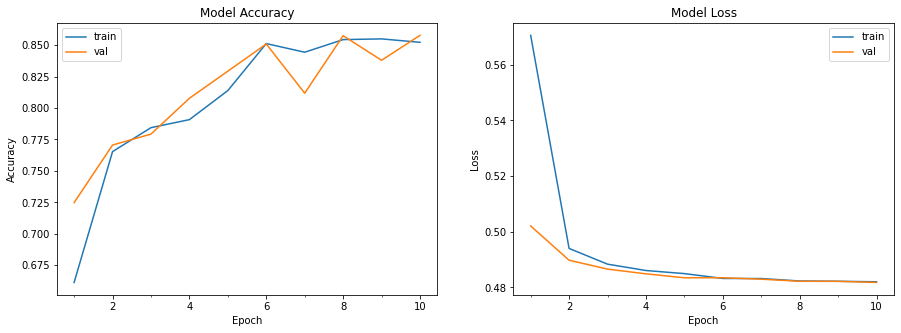

In [ ]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1, 2, figsize = (15,5))    
    
    # summarize history for accuracy
    axs[0].plot(range(1, len(model_history.history['accuracy'])+1), model_history.history['accuracy'])
    axs[0].plot(range(1, len(model_history.history['val_accuracy'])+1), model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy')
    
    axs[0].set_xticks(np.arange(1, len(model_history.history['accuracy'])+1), len(model_history.history['accuracy'])/10)
    axs[0].legend(['train','val'], loc = 'best')
    
    # summarize history for loss
    axs[1].plot(range(1, len(model_history.history['loss'])+1), model_history.history['loss'])
    axs[1].plot(range(1, len(model_history.history['val_loss'])+1), model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    
    axs[1].set_xticks(np.arange(1, len(model_history.history['loss'])+1), len(model_history.history['loss'])/10)
    axs[1].legend(['train','val'], loc = 'best')
     
    plt.show()

plot_model_history(a_e)

In [ ]:
predictions = autoencoder.predict(val_x_px)

In [ ]:
print(predictions[0].shape)

(80, 80, 3)


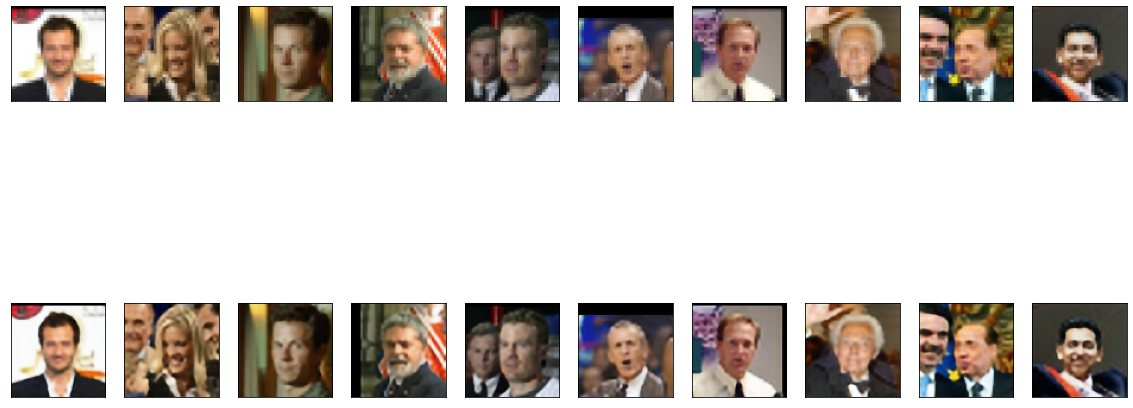

In [ ]:
n = 10
plt.figure(figsize= (20,10))

for i in range(1,n+1):
  ax = plt.subplot(2, n, i)
  plt.imshow(val_x_px[i])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(2, n, i+n)
  plt.imshow(predictions[i])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

#For 50 epochs

In [ ]:
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=4, verbose=1, mode='auto')

#min_delta : minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement.
#patience : number of epochs with no improvement after which training will be stopped


a_e = autoencoder.fit(train_x_px, train_x,
            epochs=50,
            batch_size=256,
            shuffle=True,
            validation_data=(val_x_px, val_x),
            callbacks=[early_stopper])

Epoch 1/50
47/47 [==============================] - 75s 2s/step - loss: 0.4819 - accuracy: 0.8612 - val_loss: 0.4819 - val_accuracy: 0.8555
Epoch 2/50
47/47 [==============================] - 74s 2s/step - loss: 0.4815 - accuracy: 0.8615 - val_loss: 0.4822 - val_accuracy: 0.8709
Epoch 3/50
47/47 [==============================] - 74s 2s/step - loss: 0.4819 - accuracy: 0.8549 - val_loss: 0.4817 - val_accuracy: 0.8552
Epoch 4/50
47/47 [==============================] - 74s 2s/step - loss: 0.4814 - accuracy: 0.8637 - val_loss: 0.4812 - val_accuracy: 0.8571
Epoch 5/50
47/47 [==============================] - 74s 2s/step - loss: 0.4822 - accuracy: 0.8526 - val_loss: 0.4813 - val_accuracy: 0.8536
Epoch 6/50
47/47 [==============================] - 74s 2s/step - loss: 0.4813 - accuracy: 0.8684 - val_loss: 0.4815 - val_accuracy: 0.8366
Epoch 7/50
47/47 [==============================] - 74s 2s/step - loss: 0.4814 - accuracy: 0.8570 - val_loss: 0.4811 - val_accuracy: 0.8623
Epoch 8/50
47/47 [==

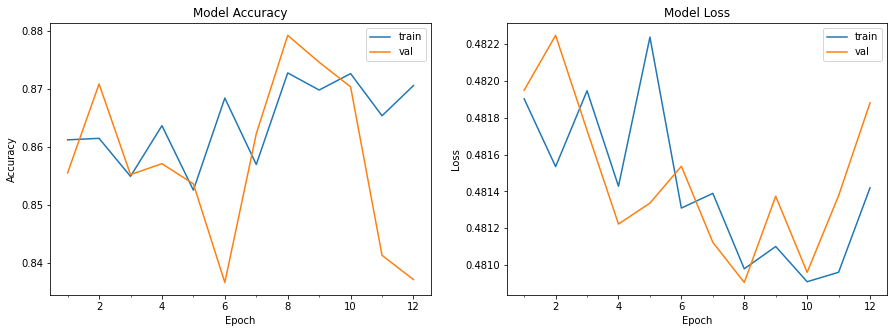

In [ ]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1, 2, figsize = (15,5))    
    
    # summarize history for accuracy
    axs[0].plot(range(1, len(model_history.history['accuracy'])+1), model_history.history['accuracy'])
    axs[0].plot(range(1, len(model_history.history['val_accuracy'])+1), model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy')
    
    axs[0].set_xticks(np.arange(1, len(model_history.history['accuracy'])+1), len(model_history.history['accuracy'])/10)
    axs[0].legend(['train','val'], loc = 'best')
    
    # summarize history for loss
    axs[1].plot(range(1, len(model_history.history['loss'])+1), model_history.history['loss'])
    axs[1].plot(range(1, len(model_history.history['val_loss'])+1), model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    
    axs[1].set_xticks(np.arange(1, len(model_history.history['loss'])+1), len(model_history.history['loss'])/10)
    axs[1].legend(['train','val'], loc = 'best')
     
    plt.show()

plot_model_history(a_e)

#Making predictions

In [ ]:
predictions = autoencoder.predict(val_x_px)

In [ ]:
print(predictions[0].shape)

(80, 80, 3)


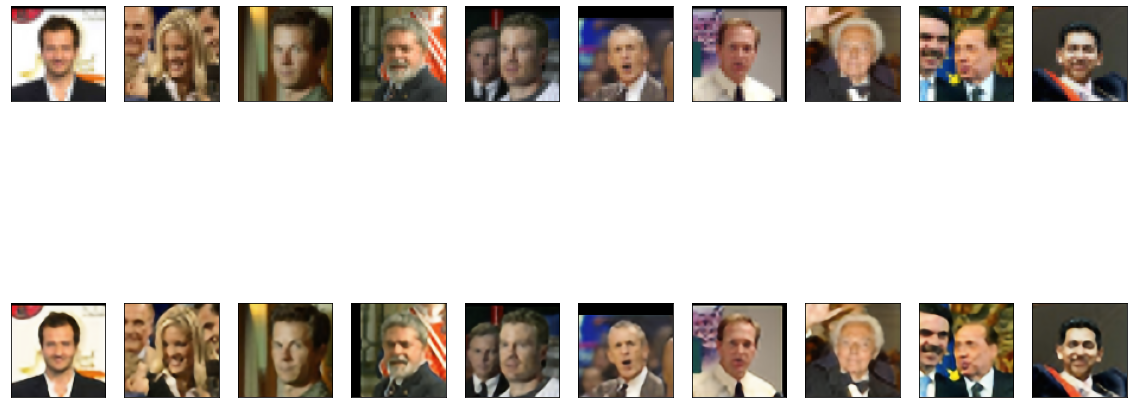

In [ ]:
n = 10
plt.figure(figsize= (20,10))

for i in range(1,n+1):
  ax = plt.subplot(2, n, i)
  plt.imshow(val_x_px[i])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(2, n, i+n)
  plt.imshow(predictions[i])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

#Conclusion

We didn't move forward with this approach because-


1.   The approach we have used was to first reduce the dimensions/ resolution to 80x80 and then increase the resolution but reduction of size of images will directly affect the resolution.
